In [16]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, GroupKFold, StratifiedGroupKFold
import random
from collections import Counter
import joblib

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE 

In [26]:
#df_main = pd.read_csv(r'data/unigram_dataset_majed_canon_author_scale.csv')
df_main = pd.read_csv(r'data/main_dataset_majed_canon_author_scale.csv')
df_main.set_index("index", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [27]:
def get_df_with_authors(df):
    df_res = df.copy()
    list_author = []
    for elem in df_res.index:
        list_author.append(elem.split('_')[1])
    print(len(set(list_author)))
    df_res['auteur'] = list_author
    return df_res

In [28]:
df_main = get_df_with_authors(df_main)

714


In [29]:
df_unibi_gram_author = df_main.iloc[:, 0:2000]
df_unibi_gram_author['canon'] = df_main['canon']
df_unibi_gram_author['auteur'] = df_main['auteur']

In [30]:
def GKF_canonized(df_main, n_splits=5, sampling=None):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced"))#{"canon":10, "non_canon":1}
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'canon'], axis=1), df_main['canon'], df_main['auteur']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'canon'], axis=1)
            y_train = train['canon']
            X_test = test.drop(['auteur', 'canon'], axis=1)
            y_test = test['canon']
            
            if sampling is not None:     
                if sampling == 'over':
                    ros = RandomOverSampler(random_state=10)
                    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
                    
                elif sampling == 'svm':
                    sm = SVMSMOTE(random_state=10)
                    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
                    
                elif sampling == 'under':
                    rus = RandomUnderSampler(random_state=10)
                    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
                    
                elif sampling == "smoteenn":
                    smote_enn = SMOTEENN(random_state=10)
                    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
                    
                elif sampling == 'smotetomek':
                    smote_tomek = SMOTETomek(random_state=10)
                    X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
                
                else:
                    print('Please follow the sampling possible values : over, under, smoteenn, smotetomek')
                    return
                                
                pipe.fit(X_resampled, y_resampled)
        
            else:
                pipe.fit(X_train, y_train)
                
            preds = pipe.predict(X_test)
        
            #print(f"\n PREDS : ")
            #print(set(zip(test.index, preds)))
            #print("\n\n")
  
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
        
    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
    
    return pipe, df_scores, bas

In [32]:
def ratio_truncate(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = df_res.canon.value_counts(normalize=True).canon
    index_noncanon = df_res[df_res['canon']  == 'non_canon'].index 
    i, j = 0, 10
    
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=10
        ratio_temp = df_res.canon.value_counts(normalize=True).canon

    return shuffle(df_res)

In [9]:
def all_non_canonical_authors(df_main):
    
    df_canon = df_main[df_main['canon']=='canon']
    conteur = Counter(df_canon.auteur)

    df = pd.DataFrame.from_dict(conteur, orient='index').reset_index()
    df = df.rename(columns={'index':'auteur', 0:'nb_romans'})
    df_auteur_canon = df[df['nb_romans']>2]

    list_auteur_non_canon = []
    
    for auteur in list(df_main.auteur):
        if auteur not in list(df_auteur_canon.auteur):
            list_auteur_non_canon.append(auteur)
            
    return list(set(list_auteur_non_canon))

In [10]:
#DELETE DATA BY GROUPS OF AUTHOR

def ratio_truncate_group(df, ratio_canon, list_non_canonical_authors):
    i = 0
    df_res = df.copy()
    random.shuffle(list_non_canonical_authors)
    ratio_temp = df_res.canon.value_counts(normalize=True).canon
    
    while ratio_temp < ratio_canon:
        index_group_auteur_non_canon = df_res[df_res['auteur'] == list_non_canonical_authors[i]].index 
        df_res.drop(index_group_auteur_non_canon, inplace = True)
        ratio_temp = df_res.canon.value_counts(normalize=True).canon
        i+=1
    print("Nb d'auteurs supprimés : ", i)
    return df_res

In [11]:
def N_canonizer_sizeopti(df_main, N_fold=5, N_sample=10, ratio=0.45, sampling=None):
    list_res = []
    #list_non_canonical_authors = list(set((df_main[df_main['canon']=='non_canon']).auteur)) # author scale
    list_non_canonical_authors = all_non_canonical_authors(df_main) # novel scale 
    
    for i in tqdm(range(N_sample)):
        df_sizeopti_last = ratio_truncate_group(df_main, ratio, list_non_canonical_authors)
        pipe, results = GKF_canonized(df_sizeopti_last, N_fold, sampling=sampling)
        list_res.append(results)
        
    all_results = pd.concat(list_res).groupby(level=0).mean().drop(['macro avg', 'weighted avg'])

    return pipe, all_results # return last pipe

In [12]:
def N_canonizer(df, N_fold=5, N_sample=10, sampling=None):
    list_res, all_bas = [], []
    for i in tqdm(range(N_sample)):
        pipe, results, bas = GKF_canonized(df, N_fold, sampling=sampling)
        list_res.append(results)
        all_bas.append(bas)
        
    all_results = pd.concat(list_res).groupby(level=0).mean().drop(['macro avg', 'weighted avg'])
    
    print(sum(all_bas)/len(all_bas))
    return pipe, all_results, all_bas # return last pipe

0.7511360107167853


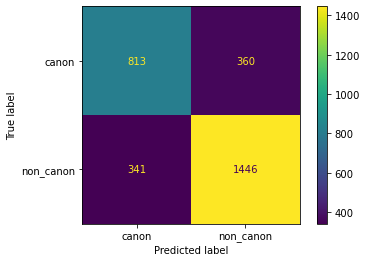

In [13]:
pipe, df_final_scores, all_bas = GKF_canonized(df_unibi_gram_author, sampling='under')

In [15]:
df_final_scores

,precision,recall,f1-score,support
canon,0.731343,0.584825,0.649929,1173.000000
non_canon,0.759149,0.858982,0.805986,1787.000000
accuracy,0.750338,0.750338,0.750338,0.750338


0.740695923146758


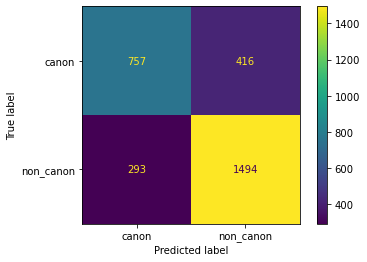

In [33]:
pipe, df_final_scores, all_bas = GKF_canonized(df_unibi_gram_author)

In [34]:
df_final_scores

,precision,recall,f1-score,support
canon,0.720952,0.645354,0.681062,1173.000000
non_canon,0.782199,0.836038,0.808223,1787.000000
accuracy,0.760473,0.760473,0.760473,0.760473


In [35]:
print(df_final_scores.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
canon     &      0.721 &   0.645 &     0.681 & 1173.000 \\
non\_canon &      0.782 &   0.836 &     0.808 & 1787.000 \\
accuracy  &      0.760 &   0.760 &     0.760 &    0.760 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5221/3649009022.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_final_scores.to_latex(float_format="%.3f"))


In [154]:
joblib.dump(pipe, 'pipes/pipeline_author_scale.pkl')

['pipes/pipeline_author_scale.pkl']

In [ ]:
pipe, df_final_scores = N_canonizer_sizeopti(df_unibi_gram_author, ratio=0.5)

In [115]:
df_final_scores

,precision,recall,f1-score,support
accuracy,0.741346,0.741346,0.741346,0.741346
canon,0.736649,0.663023,0.697827,1171.900000
non_canon,0.744645,0.805567,0.773872,1428.900000


In [241]:
#df_concat 800*2 + 800 POS
df_final_scores

,precision,recall,f1-score,support
canon,0.723240,0.639386,0.678733,1173.000000
non_canon,0.780031,0.839396,0.808625,1787.000000
accuracy,0.760135,0.760135,0.760135,0.760135
macro avg,0.751636,0.739391,0.743679,2960.000000
weighted avg,0.757526,0.760135,0.757151,2960.000000


In [192]:
#df_concat 800*2 + 800 POS, sampling = under
df_final_scores

,precision,recall,f1-score,support
canon,0.699021,0.730605,0.714464,1173.000000
non_canon,0.817762,0.793509,0.805453,1787.000000
accuracy,0.768581,0.768581,0.768581,0.768581
macro avg,0.758392,0.762057,0.759959,2960.000000
weighted avg,0.770707,0.768581,0.769396,2960.000000


In [251]:
#df_concat 800*2 
df_final_scores

,precision,recall,f1-score,support
canon,0.731510,0.615516,0.668519,1173.000000
non_canon,0.771414,0.851707,0.809574,1787.000000
accuracy,0.758108,0.758108,0.758108,0.758108
macro avg,0.751462,0.733611,0.739046,2960.000000
weighted avg,0.755601,0.758108,0.753676,2960.000000


In [253]:
#df_concat 800*2 sampling = under
df_final_scores

,precision,recall,f1-score,support
canon,0.696648,0.726343,0.711185,1173.000000
non_canon,0.815199,0.792389,0.803632,1787.000000
accuracy,0.766216,0.766216,0.766216,0.766216
macro avg,0.755923,0.759366,0.757409,2960.000000
weighted avg,0.768219,0.766216,0.766997,2960.000000


In [204]:
#df_unigram_main 
df_final_scores

,precision,recall,f1-score,support
canon,0.690049,0.721228,0.705294,1173.000000
non_canon,0.811419,0.787353,0.799205,1787.000000
accuracy,0.761149,0.761149,0.761149,0.761149
macro avg,0.750734,0.754290,0.752249,2960.000000
weighted avg,0.763322,0.761149,0.761989,2960.000000


In [141]:
#df_main
df_final_scores

,precision,recall,f1-score,support
canon,0.726539,0.613811,0.665434,1173.000000
non_canon,0.769934,0.848349,0.807242,1787.000000
accuracy,0.755405,0.755405,0.755405,0.755405
macro avg,0.748236,0.731080,0.736338,2960.000000
weighted avg,0.752737,0.755405,0.751046,2960.000000


In [96]:
#under
df_final_scores

,precision,recall,f1-score,support
canon,0.685668,0.717818,0.701374,1173.00000
non_canon,0.808891,0.783996,0.796249,1787.00000
accuracy,0.757770,0.757770,0.757770,0.75777
macro avg,0.747280,0.750907,0.748812,2960.00000
weighted avg,0.760060,0.757770,0.758652,2960.00000


In [207]:
df_final_scores.round(decimals = 2)

,precision,recall,f1-score,support
canon,0.70,0.73,0.71,1173.00
non_canon,0.82,0.79,0.80,1787.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.76,0.76,0.76,2960.00
weighted avg,0.77,0.77,0.77,2960.00


In [209]:
print(res.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
canon        &       0.70 &    0.73 &      0.71 &  1173.00 \\
non\_canon    &       0.82 &    0.79 &      0.80 &  1787.00 \\
accuracy     &       0.77 &    0.77 &      0.77 &     0.77 \\
macro avg    &       0.76 &    0.76 &      0.76 &  2960.00 \\
weighted avg &       0.77 &    0.77 &      0.77 &  2960.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_6350/138774964.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex())


In [208]:
res = df_final_scores.round(decimals = 2)
print(res.to_latex())

## NOVEL SCALE

In [18]:
def ratio_truncate(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = df_res.canon.value_counts(normalize=True).canon
    index_noncanon = df_res[df_res['canon']  == 'non_canon'].index 
    i, j = 0, 20
    
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=20
        ratio_temp = df_res.canon.value_counts(normalize=True).canon

    return shuffle(df_res)

In [19]:
def N_canonizer_sizeopti(df_main, N_fold=5, N_sample=10, ratio=0.5):
    list_res, all_bas = [], []
    for i in tqdm(range(N_sample)):
        df_sizeopti_last = ratio_truncate(df_main, ratio)
        pipe, results, bas = GKF_canonized(df_sizeopti_last, N_fold)
        list_res.append(results)
        all_bas.append(bas)
    all_results = pd.concat(list_res).groupby(level=0).mean()

    return pipe, all_results, all_bas # return last pipe

In [20]:
df_main = pd.read_csv(r'data/main_dataset_majed_canon_novel_scale.csv')
df_main.set_index("index", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [21]:
df_main = get_df_with_authors(df_main)

714


In [22]:
df_concat = pd.concat([df_main.iloc[:, 0:800], df_main.iloc[:, 1000:1800]],  axis=1)#df_main.iloc[:, 3156:3956]],
df_concat['canon']=df_main['canon']
df_concat['auteur']=df_main['auteur']

In [23]:
df_unibi_gram_novel = df_main.iloc[:, 0:2000]
df_unibi_gram_novel['canon']=df_main['canon']
df_unibi_gram_novel['auteur'] = df_main['auteur']

  0%|          | 0/10 [00:00<?, ?it/s]

0.7460655314757482
0.7034313725490196
0.7181802545579636
0.7017866357069144
0.7099780701754386
0.704968610251118
0.73453087375301
0.6886072411420708
0.683780529755762
0.6903057275541795


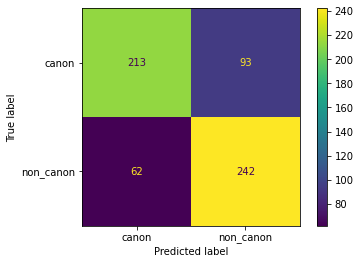

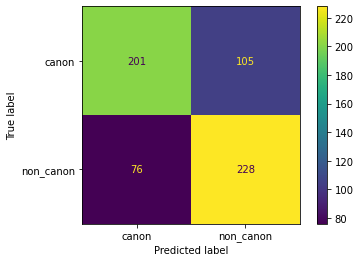

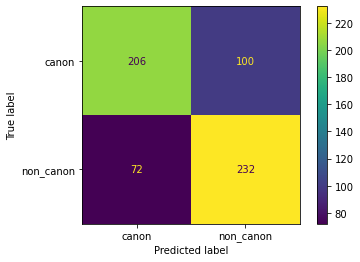

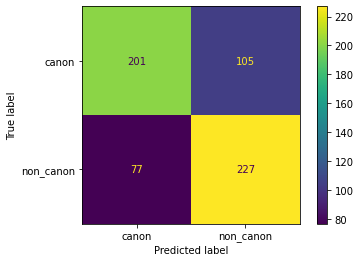

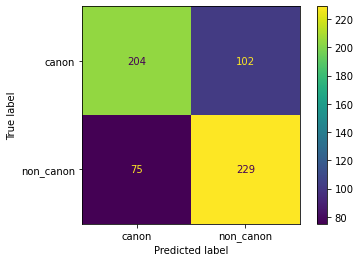

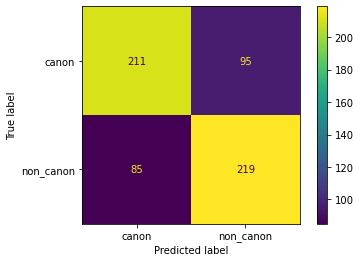

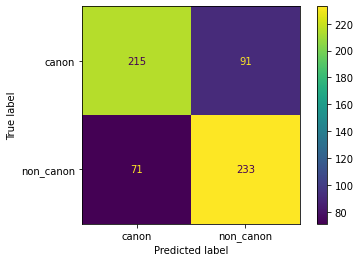

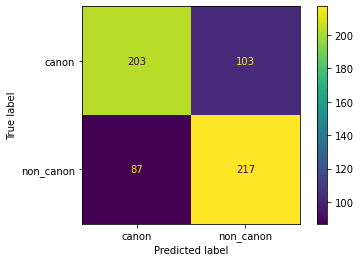

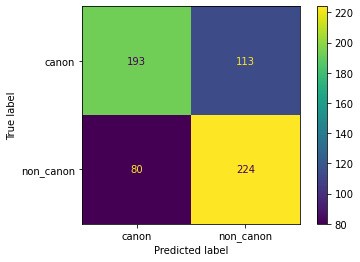

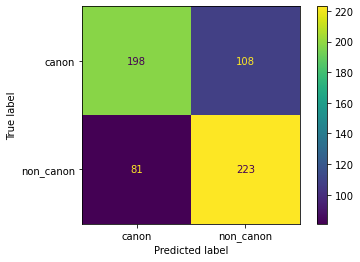

In [42]:
pipe, res, all_bas = N_canonizer_sizeopti(df_unibi_gram_novel, ratio=0.5)

In [43]:
res

,precision,recall,f1-score,support
accuracy,0.708033,0.708033,0.708033,0.708033
canon,0.727661,0.668301,0.696617,306.000000
non_canon,0.691456,0.748026,0.718550,304.000000


In [44]:
sum(all_bas)/len(all_bas)

0.7081634846921224

In [45]:
print(res.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
accuracy  &      0.708 &   0.708 &     0.708 &    0.708 \\
canon     &      0.728 &   0.668 &     0.697 &  306.000 \\
non\_canon &      0.691 &   0.748 &     0.719 &  304.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5221/3490406322.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(float_format="%.3f"))


In [342]:
res

,precision,recall,f1-score,support
accuracy,0.708824,0.708824,0.708824,0.708824
canon,0.696100,0.626797,0.659355,306.000000
non_canon,0.717851,0.775936,0.745619,374.000000


In [350]:
pipe, res, all_bas = N_canonizer_sizeopti(df_unibi_gram_novel, ratio=0.45)

  0%|          | 0/10 [00:00<?, ?it/s]

0.6858288770053476
0.7061794414735592
0.6749851455733809
0.7063279857397504
0.7131610219845514
0.6880570409982174
0.7150920974450385
0.71524064171123
0.6752822341057635
0.672756981580511


In [351]:
sum(all_bas)/len(all_bas)

0.695291146761735

In [343]:
sum(all_bas)/len(all_bas)

0.70136660724896

In [344]:
print(res.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
accuracy  &      0.709 &   0.709 &     0.709 &    0.709 \\
canon     &      0.696 &   0.627 &     0.659 &  306.000 \\
non\_canon &      0.718 &   0.776 &     0.746 &  374.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16668/3490406322.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex(float_format="%.3f"))


In [39]:
joblib.dump(pipe, 'pipes/pipeline_novel_scale.pkl')

['pipes/pipeline_novel_scale.pkl']

In [ ]:
#45, sampling = under
res

In [133]:
#45
res

,precision,recall,f1-score,support
accuracy,0.701912,0.701912,0.701912,0.701912
canon,0.688619,0.617320,0.650848,306.000000
non_canon,0.711208,0.771123,0.739859,374.000000


In [172]:
res = N_canonizer_sizeopti(df_unibi_gram, 10, 0.50)

  0%|          | 0/10 [00:00<?, ?it/s]

In [173]:
#50
res

,precision,recall,f1-score,support
accuracy,0.692500,0.692500,0.692500,0.6925
canon,0.716283,0.658170,0.685699,306.0000
non_canon,0.672096,0.728231,0.698790,294.0000


In [136]:
res = N_canonizer_sizeopti(df_unibi_gram, 10, 0.55)

  0%|          | 0/10 [00:00<?, ?it/s]

In [137]:
#55
res

,precision,recall,f1-score,support
accuracy,0.691111,0.691111,0.691111,0.691111
canon,0.750363,0.682353,0.714440,306.000000
non_canon,0.628779,0.702564,0.663312,234.000000


In [48]:
res = res.round(decimals = 3)
print(res.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
accuracy  &      0.714 &   0.714 &     0.714 &    0.714 \\
canon     &      0.688 &   0.668 &     0.678 &  306.000 \\
non\_canon &      0.735 &   0.751 &     0.743 &  374.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16668/4265497405.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex())


### Group == Subgenre

In [10]:
df_metadata_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/df_canon_spec_last.csv')
df_metadata_corpus.set_index("doc_name", inplace = True)
df_metadata_corpus = df_metadata_corpus.replace(np.nan, '')

In [24]:
def retrieve_subgenre(df_main, df_metadata_corpus):
    list_subgenre = []
    for elem in df_main.index:
        if elem in df_metadata_corpus.index:
            list_subgenre.append(df_metadata_corpus.loc[elem]['subgenre'])
        else:
            print(elem)
    return list_subgenre

In [25]:
df_main['subgenre'] = retrieve_subgenre(df_main, df_metadata_corpus)

In [26]:
df_concat = pd.concat([df_main.iloc[:, 0:800], df_main.iloc[:, 1000:1800]],  axis=1)#df_main.iloc[:, 3156:3956]],
df_concat['canon']=df_main['canon']
df_concat['subgenre']=df_main['subgenre']

In [29]:
def GKF_canonized_subgenre(df_main, n_splits=5, sampling=None):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight={"canon":1.5, "non_canon":1}))
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in tqdm(gkf.split(df_main.drop(['subgenre', 'canon'], axis=1), df_main['canon'], df_main['subgenre']), total=n_splits): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]
            #print("\n\n GROUP "+str(i)+' : \n\n')
            #print("\n\n Train set: \n\n")
            #print(list(set(list(df_main['auteur'][train_index]))))
            #print("\n\n Test set: \n\n")
            #print(list(set(list(df_main['auteur'][test_index]))))
            
            X_train = train.drop(['subgenre', 'canon'], axis=1)
            y_train = train['canon']
            X_test = test.drop(['subgenre', 'canon'], axis=1)
            y_test = test['canon']
            
            pipe.fit(X_train, y_train)
                
            preds = pipe.predict(X_test)
        
            #print(f"\n PREDS : ")
            #print(set(zip(test.index, preds)))
            #print("\n\n")
  
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
    
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose()
    
    return pipe, df_scores

In [32]:
pipe, df_res = GKF_canonized_subgenre(df_concat)

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
df_res

,precision,recall,f1-score,support
canon,0.807512,0.879795,0.842105,1173.000000
non_canon,0.916171,0.862339,0.888440,1787.000000
accuracy,0.869257,0.869257,0.869257,0.869257
macro avg,0.861841,0.871067,0.865273,2960.000000
weighted avg,0.873111,0.869257,0.870079,2960.000000


In [40]:
df_concat_cleaned = df_concat[df_concat['subgenre'] != '']

In [44]:
len(df_concat_cleaned)

1990

In [41]:
pipe, df_res = GKF_canonized_subgenre(df_concat_cleaned)

  0%|          | 0/5 [00:00<?, ?it/s]

In [42]:
df_res

,precision,recall,f1-score,support
canon,0.780987,0.834190,0.806712,778.000000
non_canon,0.888697,0.849835,0.868832,1212.000000
accuracy,0.843719,0.843719,0.843719,0.843719
macro avg,0.834842,0.842013,0.837772,1990.000000
weighted avg,0.846587,0.843719,0.844546,1990.000000


In [47]:
res = df_res.round(decimals = 2)

In [48]:
print(res.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
canon        &       0.78 &    0.83 &      0.81 &   778.00 \\
non\_canon    &       0.89 &    0.85 &      0.87 &  1212.00 \\
accuracy     &       0.84 &    0.84 &      0.84 &     0.84 \\
macro avg    &       0.83 &    0.84 &      0.84 &  1990.00 \\
weighted avg &       0.85 &    0.84 &      0.84 &  1990.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5260/138774964.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res.to_latex())


### BASELINES - 

- RANDOM BUT 60% non_canon, 40% canon (author scale)

- RANDOM BUT 90% non_canon, 10% canon (novel scale)

In [327]:
df_canon_random_author = df_unibi_gram_author.drop(['canon'], axis=1)
df_canon_random_novel = df_unibi_gram_novel.drop(['canon'], axis=1)

In [328]:
df_canon_random_author['canon'] = random.choices(['canon', 'non_canon'], weights = [1, 1.5], k = len(df_canon_random_author))
df_canon_random_novel['canon'] = random.choices(['canon', 'non_canon'], weights = [1, 9], k = len(df_canon_random_novel))

In [329]:
pipe_author, scores_author, bas = GKF_canonized(df_canon_random_author)

0.4853260589194738


In [345]:
scores_author

,precision,recall,f1-score,support
canon,0.364004,0.316067,0.338346,1139.000000
non_canon,0.604769,0.654585,0.628692,1821.000000
accuracy,0.524324,0.524324,0.524324,0.524324


In [346]:
pipe, scores, all_bas = N_canonizer_sizeopti(df_canon_random_novel, ratio=0.45)

  0%|          | 0/10 [00:00<?, ?it/s]

0.5033758145133855
0.48691544762253686
0.5241279145840421
0.49931088024145365
0.5133462434250124
0.5014654698662758
0.5481162606093912
0.5208742225595129
0.5195570442868483
0.46883695775434187


In [347]:
scores

,precision,recall,f1-score,support
accuracy,0.511324,0.511324,0.511324,0.511324
canon,0.463004,0.478641,0.469901,309.000000
non_canon,0.554062,0.538544,0.545455,371.000000


In [348]:
sum(all_bas)/len(all_bas)

0.50859262554628